In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

### importation de  la donnée de prédictions

In [2]:
pred_init = pd.read_csv('/home/apprenant/PycharmProjects/Brief-10-Employees-Turnover/data/attrition_test.csv')
train_init = pd.read_csv('/home/apprenant/PycharmProjects/Brief-10-Employees-Turnover/data/attrition_train.csv')

In [3]:
pred = pred_init.drop(['EmployeeCount','EmployeeNumber','Over18','StandardHours'], axis =1)
train = train_init.drop(['EmployeeCount','EmployeeNumber','Over18','StandardHours'], axis =1)

In [4]:
print(train.shape)

(1100, 31)


### modification de la donnée

In [5]:
X = train.copy()
y = X.pop('Attrition')

In [6]:
y = y.map(dict(Yes=1, No=0)).astype('int64')

In [7]:
num = X.select_dtypes(include = ["float64","int64"])
features_num = num.columns
print(features_num)

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')


In [8]:
cat = X.select_dtypes(include = ["object"])
features_cat = cat.columns
print(features_cat)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime'],
      dtype='object')


In [9]:
transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)


In [10]:

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

In [11]:
print(input_shape)

[51]


### création du model

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(500, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(500, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(500, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid'),
])


In [13]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC()],
)

In [14]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=500,
    epochs=20,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)

print(history_df.head())

Epoch 1/20
2/2 [==============================] - 2s 597ms/step - loss: 0.8473 - auc: 0.6287 - val_loss: 0.7507 - val_auc: 0.7334
Epoch 2/20
2/2 [==============================] - 0s 52ms/step - loss: 0.5883 - auc: 0.9439 - val_loss: 0.7320 - val_auc: 0.7511
Epoch 3/20
2/2 [==============================] - 0s 58ms/step - loss: 0.3699 - auc: 0.9896 - val_loss: 0.6968 - val_auc: 0.7622
Epoch 4/20
2/2 [==============================] - 0s 59ms/step - loss: 0.2829 - auc: 0.9980 - val_loss: 0.6979 - val_auc: 0.7749
Epoch 5/20
2/2 [==============================] - 0s 53ms/step - loss: 0.2292 - auc: 0.9995 - val_loss: 0.6772 - val_auc: 0.7777
Epoch 6/20
2/2 [==============================] - 0s 54ms/step - loss: 0.1643 - auc: 0.9997 - val_loss: 0.6520 - val_auc: 0.7849
Epoch 7/20
2/2 [==============================] - 0s 52ms/step - loss: 0.1211 - auc: 0.9998 - val_loss: 0.6321 - val_auc: 0.7897
Epoch 8/20
2/2 [==============================] - 0s 53ms/step - loss: 0.1006 - auc: 0.9999 - va

<AxesSubplot:title={'center':'AUC'}>

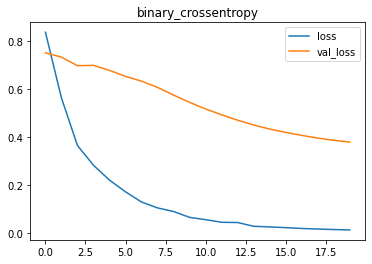

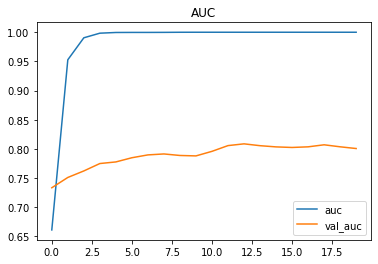

In [15]:
history_df.loc[:, ['loss', 'val_loss']].plot(title="binary_crossentropy")
history_df.loc[:, ['auc', 'val_auc']].plot(title="AUC")